In [38]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
import numpy as np

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:
n_tasks = 10
n_gps = 3

train_x = torch.linspace(0, 1, 100)

train_gps = torch.stack([
    torch.sin(train_x*5 * math.pi) 
    + torch.sin(train_x * (torch.rand(1)*3 * math.pi)) 
    + torch.randn(train_x.size()) * 0.2 for i in range(n_gps)
], -1)

In [40]:
# Mixture
known_mixtures = []
for i in range(n_tasks):
    mixture_weights = np.random.randint(0, 2, size=n_gps)
    
    # make sure its not all zeros...
    if sum(mixture_weights) == 0:
        ix = np.random.randint(n_gps) # 0, 1 or 2
        mixture_weights[ix] = 1
        
    known_mixtures.append(mixture_weights)
known_mixtures = torch.from_numpy(np.array(known_mixtures))

In [41]:
train_y = torch.stack([train_gps * known_mixtures[i].reshape(1,-1) 
                for i in range(n_tasks)])

In [42]:
train_y = torch.sum(train_y, axis=2)

In [43]:
train_y = train_y.T

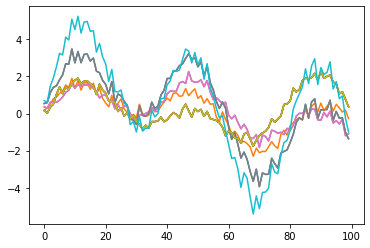

In [44]:
plt.plot(train_y);

In [45]:
    covs = []
    for i in range(1, n_gps+1):
        #eta_t = pm.InverseGamma(f'eta_t_{i}', 4)
        #ell_t = pm.HalfNormal(f'ell_t_{i}', 1)
        #eta_p = pm.HalfNormal(f'eta_p_{i}', 1.5)
        #ell_p = pm.HalfNormal(f'ell_p_{i}', 0.5)
        #cov = (eta_t**2 * pm.gp.cov.ExpQuad(input_dim=1, ls=ell_t)
        #      +eta_p**2 * pm.gp.cov.ExpQuad(input_dim=1, ls=ell_p))
        cov = gpytorch.kernels.RBFKernel()
        covs.append(cov)
    
    # apply mixtures to covariances
    selected_covs = []
    mixed_covs = []
    for i in range(n_tasks):
        mixture_weights = known_mixtures[i]
        for w_ix in range(n_gps):
            w = mixture_weights[w_ix]
            if w == 1.0:
                selected_covs.append(covs[w_ix])
        mixed_cov = selected_covs[0]
        for cov in range(1,len(selected_covs)):
            mixed_cov += selected_covs[cov] # because GP(cov1 + cov2) = GP(cov1) + GP(cov2)
        mixed_covs.append(mixed_cov) 
        selected_covs = [] # clear out cov list

In [46]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, cov):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = cov
        
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


model_list = []
likelihood_list = []
for i in range(n_tasks):
    likelihood_list.append(gpytorch.likelihoods.GaussianLikelihood())
    model_list.append(ExactGPModel(train_x, train_y[:,i], likelihood_list[i], mixed_covs[i]))

    
model = gpytorch.models.IndependentModelList(*model_list)
likelihood = gpytorch.likelihoods.LikelihoodList(*likelihood_list)

In [47]:
#class MultitaskGPModel(gpytorch.models.ExactGP):
#    def __init__(self, train_x, train_y, likelihood):
#        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
#        self.mean_module = gpytorch.means.MultitaskMean(
#           gpytorch.means.ConstantMean(), num_tasks=n_tasks
#        )
#        self.covar_module = gpytorch.kernels.MultitaskKernel(
#            gpytorch.kernels.RBFKernel() + gpytorch.kernels.PeriodicKernel(), num_tasks=n_tasks, rank=1
#        )
#
#    def forward(self, x):
#        mean_x = self.mean_module(x)
#        covar_x = self.covar_module(x)
#        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)
#
#
#likelihood1 = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=n_tasks)
#model1 = MultitaskGPModel(train_x, train_y1, likelihood1)
#
#likelihood2 = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=n_tasks)
#model2 = MultitaskGPModel(train_x, train_y2, likelihood2)
#
#model = gpytorch.models.IndependentModelList(model1, model2)
#likelihood = gpytorch.likelihoods.LikelihoodList(model1.likelihood, model2.likelihood)

In [48]:
from gpytorch.mlls import SumMarginalLogLikelihood

mll = SumMarginalLogLikelihood(likelihood, model)

In [49]:
model

IndependentModelList(
  (models): ModuleList(
    (0): ExactGPModel(
      (likelihood): GaussianLikelihood(
        (noise_covar): HomoskedasticNoise(
          (raw_noise_constraint): GreaterThan(1.000E-04)
        )
      )
      (mean_module): ConstantMean()
      (covar_module): AdditiveKernel(
        (kernels): ModuleList(
          (0): RBFKernel(
            (raw_lengthscale_constraint): Positive()
          )
          (1): RBFKernel(
            (raw_lengthscale_constraint): Positive()
          )
        )
      )
    )
    (1): ExactGPModel(
      (likelihood): GaussianLikelihood(
        (noise_covar): HomoskedasticNoise(
          (raw_noise_constraint): GreaterThan(1.000E-04)
        )
      )
      (mean_module): ConstantMean()
      (covar_module): RBFKernel(
        (raw_lengthscale_constraint): Positive()
      )
    )
    (2): ExactGPModel(
      (likelihood): GaussianLikelihood(
        (noise_covar): HomoskedasticNoise(
          (raw_noise_constraint): GreaterTh

In [50]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iterations = 2 if smoke_test else 100


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

for i in range(training_iterations):
    optimizer.zero_grad()
    output = model(*model.train_inputs)
    loss = -mll(output, model.train_targets)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
    optimizer.step()

Iter 1/100 - Loss: 1.782
Iter 2/100 - Loss: 1.726
Iter 3/100 - Loss: 1.674
Iter 4/100 - Loss: 1.626
Iter 5/100 - Loss: 1.584
Iter 6/100 - Loss: 1.545
Iter 7/100 - Loss: 1.511
Iter 8/100 - Loss: 1.481
Iter 9/100 - Loss: 1.453
Iter 10/100 - Loss: 1.429
Iter 11/100 - Loss: 1.404
Iter 12/100 - Loss: 1.379
Iter 13/100 - Loss: 1.348
Iter 14/100 - Loss: 1.308
Iter 15/100 - Loss: 1.254
Iter 16/100 - Loss: 1.181
Iter 17/100 - Loss: 1.094
Iter 18/100 - Loss: 1.004
Iter 19/100 - Loss: 0.926
Iter 20/100 - Loss: 0.866
Iter 21/100 - Loss: 0.821
Iter 22/100 - Loss: 0.787
Iter 23/100 - Loss: 0.758
Iter 24/100 - Loss: 0.732
Iter 25/100 - Loss: 0.709
Iter 26/100 - Loss: 0.686
Iter 27/100 - Loss: 0.665
Iter 28/100 - Loss: 0.645
Iter 29/100 - Loss: 0.626
Iter 30/100 - Loss: 0.607
Iter 31/100 - Loss: 0.589
Iter 32/100 - Loss: 0.571
Iter 33/100 - Loss: 0.555
Iter 34/100 - Loss: 0.539
Iter 35/100 - Loss: 0.524
Iter 36/100 - Loss: 0.510
Iter 37/100 - Loss: 0.497
Iter 38/100 - Loss: 0.485
Iter 39/100 - Loss: 0

In [73]:
# Set into eval mode
model.eval()
likelihood.eval()

# Make predictions (use the same test points)
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1.2, 200)
    # This contains predictions for both outcomes as a list
    #predictions = likelihood(*model(test_x, test_x))
    predictions = likelihood(*model(*[test_x for i in range(10)]))

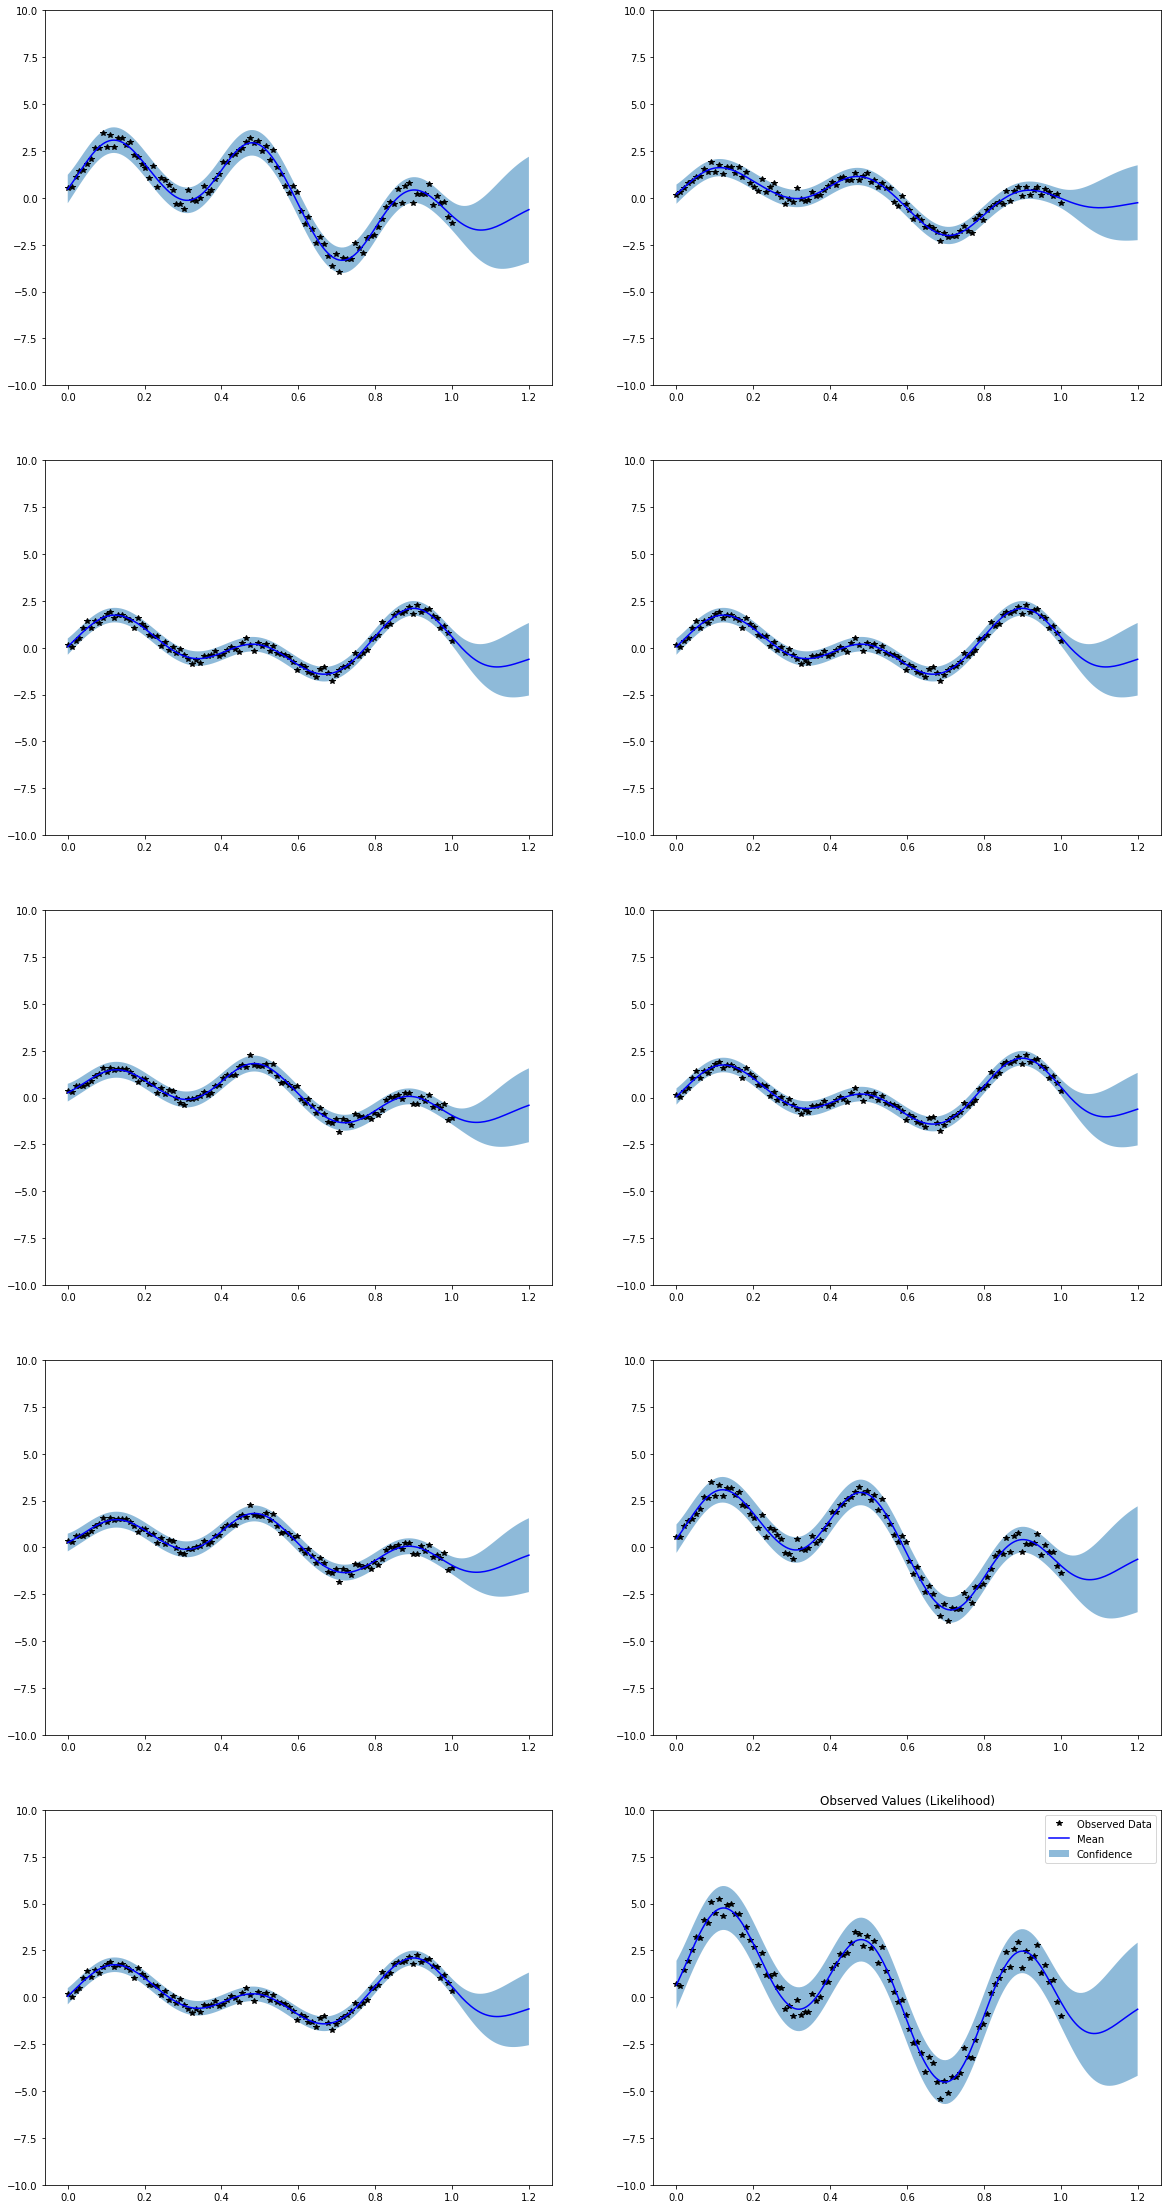

In [74]:
# Initialize plots
f, ax = plt.subplots(5, 2, figsize=(20, 40))
ax = ax.ravel()
for submodel, prediction, j in zip(model.models, predictions, range(10)):
    mean = prediction.mean
    lower, upper = prediction.confidence_region()
    tr_x = submodel.train_inputs[0].detach().numpy()
    tr_y = submodel.train_targets.detach().numpy()
    # Plot training data as black stars
    ax[j].plot(tr_x, tr_y, 'k*')
    # Predictive mean as blue line
    ax[j].plot(test_x.numpy(), mean.numpy(), 'b')
    # Shade in confidence
    ax[j].fill_between(test_x.numpy(), lower.detach().numpy(), upper.detach().numpy(), alpha=0.5)
    ax[j].set_ylim([-10, 10])
    
    plt.legend(['Observed Data', 'Mean', 'Confidence'])
    plt.title('Observed Values (Likelihood)')

None